## mRKS method

Please check the original paper:\
\[1\] [Ryabinkin, Kohut and Staroverov, PRL 115, 083001 (2015)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.083001) \
\[2\] [Ospadov, Ryabinkin and Staroverov, J. Chem. Phys. 146, 084103 (2017)](https://doi.org/10.1063/1.4975990) \
\[3\] [Staroverov, Ospadov, Advances in Quantum Chemistry, Volume 79 (2019)](https://doi.org/10.1016/bs.aiq.2019.04.002).

Note that currently only Psi4.CIWavefunction supports two-particle density matrices (tpdm). CISD is used in this example. CASSCF or FCI are also available.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True}) 
psi4.set_memory(int(2.50e10))
psi4.set_num_threads(4)
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

In [10]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  "opdm": True,  # This is necessary for mRKS
                  "tpdm": True,  # This is necessary for mRKS
                  'DFT_SPHERICAL_POINTS': 110,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                 })  # Spin-Restricted

# IMPORTANT NOTE: ONLY psi4.CIWavefunction or RHF is supported.
wfn = psi4.properties("detci/cc-pcvdz", return_wfn=True, molecule=Ne, properties=["dipole"])[1]

ine = n2v.Inverter.from_wfn(wfn)

Similar to OuCarter method, the mRKS calculation is done on the DFT spherical grid. But another grid can be specified for plotting purposes.

In [5]:
x = np.linspace(-3,5,801)
y = [0]
z = [0]
grid, shape = ine.eng.grid.generate_grid(x,y,z)

$v_{xc}$ is generated through a self-consistent method where the potential is updated as:
$$v_{xc}(r)=v_{xc}^{\rm hole}(r) + \bar{\epsilon}^{\rm KS}(r) - \bar{\epsilon}^{\rm WF}(r) + \frac{\tau^{\rm WF}_P(r)}{n^{\rm WF}(r)} - \frac{\tau^{\rm KS}_P(r)}{n^{\rm KS}(r)}.$$
The defination of each term can be found in the original regerences or in n2v paper. In the calculation, most computational time is consumed in calculating
$$v_{xc}^{\rm hole}(r)=\int dr_2 \frac{n_{xc}(r, r_2)}{|r-r_2|},$$
which is calculated by numerical quadrature on the DFT spherical grid as pre-defined in the psi4 option. Since the Fock component of $v_{xc}^{\rm hole}$ takes a double integral, the actual computational time is $O(n^2m^2)$, where $n$ is the number of grid points and $m$ is the number of gaussian basis set. ALso, notice the singularity in the integral above, clearly, numerical qudrature is not the best idea to handel this. For this reason, a parameter **sing** for define the numerical singulairy, which might also change the performance and smoothness.\
It should be mentioned that, even $\tau_P$ is more stable than $\tau$ in the original work RKS method \[1\], it is still unstablility in the convergence path. This is the main reason **frac_old** is set to 0.8.\
Also, similar to OuCarter method, for a good initial guess is obtained by setting **init**, which is SCAN functional in this case.

In [6]:
# Let's do the calculation. The vxc will be stored in ine.grid_vxc:
ine.invert("mRKS", vxc_grid=grid, opt_max_iter=30, frac_old=0.8, init="scan")

Memory taken by ERI integral matrix and 2pdm is about: 0.003 GB.
vxchole quadrature double integral starts (21004 points): ..........

Totally 21004 grid points takes 184.09s with max 256 points in a block.
Iter: 1, Density Change: 5.15e-03, Eigenvalue Change: 6.15e+00, Potential Change: 1.87e+00.
Iter: 2, Density Change: 5.76e-05, Eigenvalue Change: 1.46e-01, Potential Change: 2.08e-02.
Iter: 3, Density Change: 1.68e-05, Eigenvalue Change: 2.31e-03, Potential Change: 1.54e-02.
Iter: 4, Density Change: 1.12e-05, Eigenvalue Change: 2.00e-03, Potential Change: 1.28e-02.
Iter: 5, Density Change: 7.52e-06, Eigenvalue Change: 1.83e-03, Potential Change: 1.17e-02.
Iter: 6, Density Change: 5.13e-06, Eigenvalue Change: 1.74e-03, Potential Change: 1.13e-02.
Iter: 7, Density Change: 3.58e-06, Eigenvalue Change: 1.68e-03, Potential Change: 1.11e-02.
Iter: 8, Density Change: 2.58e-06, Eigenvalue Change: 1.64e-03, Potential Change: 1.11e-02.
Iter: 9, Density Change: 1.94e-06, Eigenvalue Change: 1.6

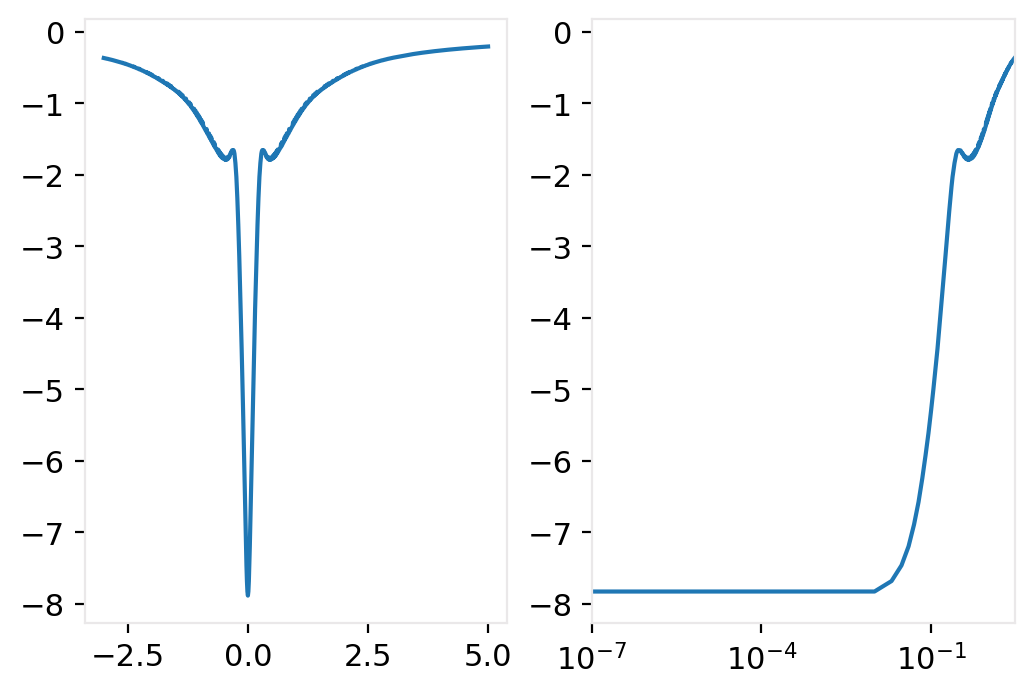

In [8]:
fig, axes = plt.subplots(1,2,dpi=200)
axes[0].plot(x, ine.grid_vxc, label="vxc")
#
axes[1].plot(x, ine.grid_vxc, label="vxc")
axes[1].set_xlim(1e-7, 3)
axes[1].set_xscale("log")